# Project 08: Epidemium - Image processing before model training
## Bloc n°6 - Jedha - dsmft - Paris14
### Joseph Abitbol & Nicolas Hegerle

## Library imports and function definition

### <ins>Import the necessary libraries </ins>

In [32]:
#import the necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

import os
import shutil
import cv2
import matplotlib.pyplot as plt

### <ins>Define functions</ins>

In [33]:
# function to transform images
def img_filtering(file_path, hsv_low = (30, 100, 0), hsv_high = (140, 255, 255), strategy = "filter_out"):
    '''
    Takes an image file and transforms it based on hsv bounderies and strategy set by the user

    Parameters:
    file_path: string, the path to on image file
    hsv_low: tuple, lower bounderies of (hue, saturation, value). Default = (30, 100, 0)
    hsv_high: tuple, higher bouderies of (hue, saturation, value). Default = (140, 255, 255)
    strategy: string, choice of "keep" or "filter_out". Default = "filter_out" will keep the colors out of those bounderies. "keep", will keep the colors included in the hsv_low/hsv_high bounderies. 

    Returns:
    an RGB cv2 image file that can be saved or displayed using matplotlib

    Default:
    strategy = "filter_out" => keep red, filter out the rest

    See https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv/48367205#48367205 for an example on how to choose hsv_low/high

    '''


    img = cv2.imread(file_path) # read the image at path file path
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # change the colormap to hsv
    mask = cv2.inRange(hsv, hsv_low, hsv_high) # select the range of colors you want to exclude
    if strategy == "keep":
        imask = mask > 0 # return a boolean of the mask where the values are > 0 <=> the colors you want to keep
        img_filtered = np.zeros_like(img, np.uint8) # generate a numpy array of 0 like the mask
        img_filtered[imask] = img[imask] # replace zeros by the value of the pixels from image where imask == 0 <=> the color you want to keep
    elif strategy == "filter_out":
        imask = mask == 0 # return a boolean of the mask where the values are = 0 <=> the colors you want to exclude
        img_filtered = np.zeros_like(img, np.uint8) # generate a numpy array of 0 like the mask
        img_filtered[imask] = img[imask] # replace zeros by the value of the pixels from image where imask == 0 <=> the color you want to keep

    img_filtered = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2RGB)

    return img_filtered

### <ins>Code usage example to visually check filtering on a selected image</ins>

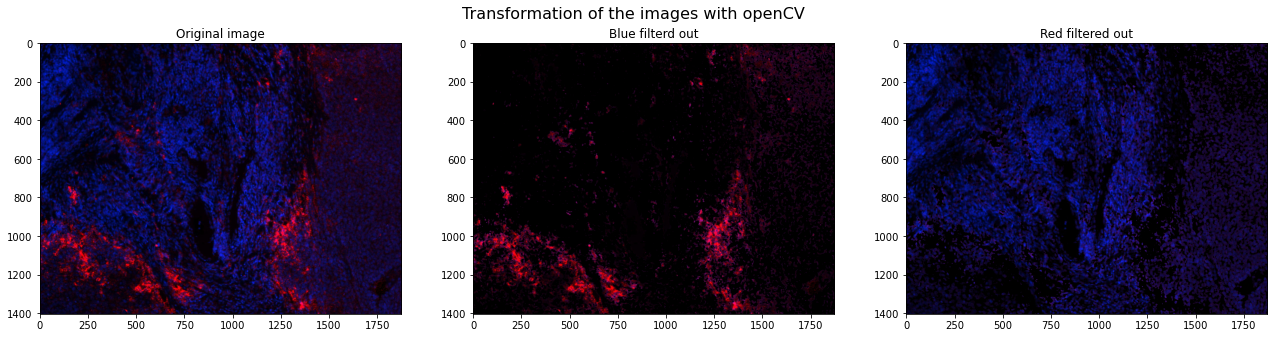

In [34]:
path = "raw_data/KORL_images/cell_infla_4/ac8a8b_[16004,53329]_composite_image.jpg" # path to your image file
img = cv2.imread(path) # read the image with opencv

filt_img = img_filtering(path, strategy = "filter_out")
filt_im_2 = img_filtering(path, strategy = 'keep')

#change the color scale of the images to fit matplotlib
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#draw the subplot to show the transformation
fig, ax = plt.subplots(1, 3, figsize =(22, 5))
fig.suptitle('Transformation of the images with openCV', fontsize = 16)
ax[0].set_title('Original image')
ax[1].set_title('Blue filterd out')
ax[2].set_title('Red filtered out')
ax[0].imshow(RGB_img)
ax[1].imshow(filt_img)
ax[2].imshow(filt_im_2)
plt.show()


## Processing of all image data

In [ ]:
# import datasets to retrieve the ids and change column names to lower case
data_train = pd.read_csv("raw_data/avatarsV2_train.csv", parse_dates=[3,4])
data_train.rename(columns = {col:col.lower() for col in data_train.columns}, inplace = True)

data_test = pd.read_csv("raw_data/avatarsV2_test_X.csv", parse_dates=[3,4])
data_test.rename(columns = {col:col.lower() for col in data_test.columns}, inplace = True)

#  list of the uniqure patient ids for the train and the test set
train_pids = data_train['id'].unique()
test_pids = data_test['id'].unique()

# initialize a dataset to store all the img location data => file name, dir name
img_loc_all = pd.DataFrame(columns = ['id', 'set', 'img_file', 'raw_img_dir', 'img_rename'])

# list of img formats produced
img_formats = ["raw", "red", "blue"]

# paths to which the img files will be copied
train_path = "src/sorted_img/train/"
test_path = "src/sorted_img/test/"

# create the list of directory names containing the image files
raw_dir_list = [d for d in os.listdir("raw_data/KORL_images/") if not d.startswith('.')]

# lets loop

for img_dir in raw_dir_list:
    
    img_files = [i for i in os.listdir("raw_data/KORL_images/{}".format(img_dir)) if not i.startswith('.')] # list of image files per folder
    
    if img_dir != "seg_tissu":

        for img_file in img_files:
            pid = img_file.split('_')[0]
            raw_img_path = f"raw_data/KORL_images/{img_dir}/{img_file}"

            red = img_filtering(raw_img_path, strategy = 'keep')
            blue = img_filtering(raw_img_path, strategy = 'filter_out')

            to_append = {
                    'id' : pid,
                    'img_file' : img_file,
                    'raw_img_dir' : img_dir,
                    }

            if pid in train_pids:
                cp_img_path = f"{train_path}raw_{img_dir}_{img_file}"
                shutil.copy(raw_img_path, cp_img_path)
                
                red_img_path = f"{train_path}red_{img_dir}_{img_file}"
                cv2.imwrite(red_img_path, red)                
                
                blue_img_path = f"{train_path}blue_{img_dir}_{img_file}"
                cv2.imwrite(blue_img_path, blue)

                for img_format in img_formats:
                    to_append['set'] = 'train'
                    to_append['img_rename'] = f"{img_format}_{img_dir}_{img_file}"
                    img_loc_all = img_loc_all.append(to_append, ignore_index=True)

            elif pid in test_pids:
                cp_img_path = f"{test_path}raw_{img_dir}_{img_file}"
                shutil.copy(raw_img_path, cp_img_path)
                
                red_img_path = f"{test_path}red_{img_dir}_{img_file}"
                cv2.imwrite(red_img_path, red)                
                
                blue_img_path = f"{test_path}blue_{img_dir}_{img_file}"
                cv2.imwrite(blue_img_path, blue)

                for img_format in img_formats:
                    to_append['set'] = 'test'
                    to_append['img_rename'] = f"{img_format}_{img_dir}_{img_file}"
                    img_loc_all = img_loc_all.append(to_append, ignore_index=True)

    else: # if img dir = seg_tissu we don't transform the images

        for img_file in img_files:
            pid = img_file.split('_')[0]
            raw_img_path = f"raw_data/KORL_images/{img_dir}/{img_file}"

            to_append = {
                    'id' : pid,
                    'img_file' : img_file,
                    'raw_img_dir' : img_dir,
                    }

            if pid in train_pids:
                cp_img_path = f"{train_path}raw_{img_dir}_{img_file}"
                shutil.copy(raw_img_path, cp_img_path)
                to_append['set'] = 'train'
                to_append['img_rename'] = f"raw_{img_dir}_{img_file}"
                img_loc_all = img_loc_all.append(to_append, ignore_index=True)
            
            elif pid in test_pids:
                cp_img_path = f"{test_path}raw_{img_dir}_{img_file}"
                shutil.copy(raw_img_path, cp_img_path)
                to_append['set'] = 'test'
                to_append['img_rename'] = f"raw_{img_dir}_{img_file}"
                img_loc_all = img_loc_all.append(to_append, ignore_index=True)

# save datasets
img_loc_all['img_format'] = img_loc_all['img_rename'].apply(lambda x : x.split('_')[0])
img_loc_all.to_csv("src/img_data.csv")

# merge the img_dataset with the train_data and save them for future use => keeps only training data info
train_img_data_all = img_loc_all.merge(data_train, on = 'id')
train_img_data_all['img_dir'] = "src/sorted_img/train/"
train_img_data_all.to_csv("src/train/train_img_data.csv", header=True)

# merge the img_dataset with test_data and save them for future use => keeps only test data info
test_img_data_all = img_loc_all.merge(data_test, on = 'id')
test_img_data_all['img_dir'] = "src/sorted_img/test/"
test_img_data_all.to_csv("src/test/test_img_data.csv", header=True)

# save a csv for each individual cell type if needed later
for img_dir in raw_dir_list:

    mask_train = (img_loc_all['raw_img_dir'] == img_dir) & (img_loc_all['set'] == 'train')
    df_train = img_loc_all.loc[mask_train] 
    df_train.reset_index(drop=True, inplace=True)
    df_train.to_csv("src/train/split_train_img_data/{}_img_data.csv".format(img_dir), header=True)

    mask_test = (img_loc_all['raw_img_dir'] == img_dir) & (img_loc_all['set'] == 'test')
    df_test = img_loc_all.loc[mask_test]    
    df_test.reset_index(drop=True, inplace=True)
    df_test.to_csv("src/test/split_test_img_data/{}_img_data.csv".format(img_dir), header=True)

## Check that everything is coherent

In [5]:
display(img_loc_all.head())
display(train_img_data_all.head())
display(test_img_data_all.head())

,id,set,img_file,raw_img_dir,img_rename,img_format
0,b3c9bb,train,"b3c9bb_[15439,53451]_composite_image.jpg",cell_infla_1,"raw_cell_infla_1_b3c9bb_[15439,53451]_composit...",raw
1,b3c9bb,train,"b3c9bb_[15439,53451]_composite_image.jpg",cell_infla_1,"red_cell_infla_1_b3c9bb_[15439,53451]_composit...",red
2,b3c9bb,train,"b3c9bb_[15439,53451]_composite_image.jpg",cell_infla_1,"blue_cell_infla_1_b3c9bb_[15439,53451]_composi...",blue
3,a7b285,test,"a7b285_[10654,60207]_composite_image.jpg",cell_infla_1,"raw_cell_infla_1_a7b285_[10654,60207]_composit...",raw
4,a7b285,test,"a7b285_[10654,60207]_composite_image.jpg",cell_infla_1,"red_cell_infla_1_a7b285_[10654,60207]_composit...",red


,id,set,img_file,raw_img_dir,img_rename,img_format,oms,sexe (0=f 1=m),ddn,date biopsie,age au diag,deces code,code recidive,localisation,rnascope,t,n,m,tabac,alcool,data,os,img_dir
0,b3c9bb,train,"b3c9bb_[15439,53451]_composite_image.jpg",cell_infla_1,"raw_cell_infla_1_b3c9bb_[15439,53451]_composit...",raw,1,1,1945-05-05,2014-07-04,69,0,0,Oropharynx,1,2,1,0,0,1,Image + clinical,65,src/sorted_img/train/
1,b3c9bb,train,"b3c9bb_[15439,53451]_composite_image.jpg",cell_infla_1,"red_cell_infla_1_b3c9bb_[15439,53451]_composit...",red,1,1,1945-05-05,2014-07-04,69,0,0,Oropharynx,1,2,1,0,0,1,Image + clinical,65,src/sorted_img/train/
2,b3c9bb,train,"b3c9bb_[15439,53451]_composite_image.jpg",cell_infla_1,"blue_cell_infla_1_b3c9bb_[15439,53451]_composi...",blue,1,1,1945-05-05,2014-07-04,69,0,0,Oropharynx,1,2,1,0,0,1,Image + clinical,65,src/sorted_img/train/
3,b3c9bb,train,"b3c9bb_[16699,54588]_composite_image.jpg",cell_infla_1,"raw_cell_infla_1_b3c9bb_[16699,54588]_composit...",raw,1,1,1945-05-05,2014-07-04,69,0,0,Oropharynx,1,2,1,0,0,1,Image + clinical,65,src/sorted_img/train/
4,b3c9bb,train,"b3c9bb_[16699,54588]_composite_image.jpg",cell_infla_1,"red_cell_infla_1_b3c9bb_[16699,54588]_composit...",red,1,1,1945-05-05,2014-07-04,69,0,0,Oropharynx,1,2,1,0,0,1,Image + clinical,65,src/sorted_img/train/


,id,set,img_file,raw_img_dir,img_rename,img_format,oms,sexe (0=f 1=m),ddn,date biopsie,age au diag,deces code,code recidive,localisation,rnascope,t,n,m,tabac,alcool,data,img_dir
0,a7b285,test,"a7b285_[10654,60207]_composite_image.jpg",cell_infla_1,"raw_cell_infla_1_a7b285_[10654,60207]_composit...",raw,1,1,1945-10-17,2015-03-21,69,0,0,Oropharynx,0,2,1,0,0,0,Image + clinical,src/sorted_img/test/
1,a7b285,test,"a7b285_[10654,60207]_composite_image.jpg",cell_infla_1,"red_cell_infla_1_a7b285_[10654,60207]_composit...",red,1,1,1945-10-17,2015-03-21,69,0,0,Oropharynx,0,2,1,0,0,0,Image + clinical,src/sorted_img/test/
2,a7b285,test,"a7b285_[10654,60207]_composite_image.jpg",cell_infla_1,"blue_cell_infla_1_a7b285_[10654,60207]_composi...",blue,1,1,1945-10-17,2015-03-21,69,0,0,Oropharynx,0,2,1,0,0,0,Image + clinical,src/sorted_img/test/
3,a7b285,test,"a7b285_[13407,58051]_composite_image.jpg",cell_infla_1,"raw_cell_infla_1_a7b285_[13407,58051]_composit...",raw,1,1,1945-10-17,2015-03-21,69,0,0,Oropharynx,0,2,1,0,0,0,Image + clinical,src/sorted_img/test/
4,a7b285,test,"a7b285_[13407,58051]_composite_image.jpg",cell_infla_1,"red_cell_infla_1_a7b285_[13407,58051]_composit...",red,1,1,1945-10-17,2015-03-21,69,0,0,Oropharynx,0,2,1,0,0,0,Image + clinical,src/sorted_img/test/


In [36]:
# check coherence of the raw data and processed data
root_dirs = [f"raw_data/KORL_images/{d}" for d in os.listdir("raw_data/KORL_images/") if not d.startswith('.')] + ["src/sorted_img/train/", "src/sorted_img/test/"]

for path in root_dirs:
    totalFiles = 0
    for base, dirs, files in os.walk(path):

        for Files in files:
            if Files[0] != '.':
                totalFiles += 1


    print('Counted {} img_files in {}.'.format(totalFiles, path))


Counted 179 img_files in raw_data/KORL_images/cell_infla_1.
Counted 179 img_files in raw_data/KORL_images/cell_tum_infla_3.
Counted 358 img_files in raw_data/KORL_images/seg_tissu.
Counted 179 img_files in raw_data/KORL_images/cell_infla_2.
Counted 179 img_files in raw_data/KORL_images/cell_infla_5.
Counted 179 img_files in raw_data/KORL_images/cell_infla_4.
Counted 179 img_files in raw_data/KORL_images/cell_tum_infla_6.
Counted 2920 img_files in src/sorted_img/train/.
Counted 660 img_files in src/sorted_img/test/.


* <font size = 5> Nb of img files we should recover after processing: 179 x 6 x 3 + 358 = 3580</font>
* <font size = 5> Actual nb of img files retrieved: 2920 + 660 = 3580</font>
* <font size = 5> All good

In [37]:
# check patient ids
print("{} unique train set ids".format(data_train['id'].nunique()))
print("{} unique test set ids".format(data_test['id'].nunique()))
print("{} unique ids in img_loc_all".format(img_loc_all['id'].nunique()))
print("Expected {} ids total".format(data_train['id'].nunique()+data_test['id'].nunique()))

52 unique train set ids
9 unique test set ids
51 unique ids in img_loc_all
Expected 61 ids total


In [38]:
# check the number of patient ids found in the ig files

raw_dir_list = [d for d in os.listdir("raw_data/KORL_images/") if not d.startswith('.')]
img_pids = []

for img_dir in raw_dir_list:
    
    img_files = [i for i in os.listdir("raw_data/KORL_images/{}".format(img_dir)) if not i.startswith('.')] #list of image files per folder

    for img_file in img_files:
        pid = img_file.split('_')[0]
        img_pids.append(pid)

img_pids = set(img_pids)
len(img_pids)

51

In [39]:
# create the list of all expected ids between test and train
all_pids = pd.concat([data_train['id'], data_test['id']])

# check where we are lissing ids
raw_dir_list = [d for d in os.listdir("raw_data/KORL_images/") if not d.startswith('.')]
img_pids = []

for img_dir in raw_dir_list:
    
    img_files = [i for i in os.listdir("raw_data/KORL_images/{}".format(img_dir)) if not i.startswith('.')] #list of image files per folder

    for img_file in img_files:
        pid = img_file.split('_')[0]
        img_pids.append(pid)

img_pids = set(img_pids)

print('Patient ids missing in the image ids:')
missing_med_pids = [] # med stands for medical data
for i in all_pids:
    if i not in list(img_pids):
        missing_med_pids.append(i)
print(missing_med_pids)

print('\nImg ids missing in the patient ids:')
missing_img_pids = []
for i in img_pids:
    if i not in list(all_pids):
        missing_img_pids.append(i)
print(missing_img_pids)


Patient ids missing in the image ids:
['a63042', 'aef4f0', 'b15d33', 'b54aba', 'a7660c', 'a9886a', 'a71943', 'ab076b', 'a9d4f0', 'a5e38c']

Img ids missing in the patient ids:
[]


## Conclusion
<font size = "4">
-  We have ten patients for which we do not have image data of any sort <br>